# EDA which makes sense (TPSMAY22)

After a general overview of the data, this EDA shows in particular:
- The distributions of the features and the information they give about the target
- [How to deal with the string feature `f_27`](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense#The-string-feature) (→ feature engineering)
- [How to exploit the three most important feature interactions](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense#Top-three-feature-interactions) (→ feature engineering)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])

Let's start by reading the data and looking at the first few rows:

In [2]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')

print()
print('Train')
display(train.head(3))

print()
print('Test')
display(test.head(3))

print('Dataframe shapes:', train.shape, test.shape)
print()


Train


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,...,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,...,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,...,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1



Test


,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,...,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,...,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,...,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1


Dataframe shapes: (900000, 33) (700000, 32)



We have 900000 training samples and 700000 test samples. Both dataframes have an id column and 31 features. There are 16 float features, 14 int features and one string feature. There are no missing values:

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 33 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      900000 non-null  int64  
 1   f_00    900000 non-null  float64
 2   f_01    900000 non-null  float64
 3   f_02    900000 non-null  float64
 4   f_03    900000 non-null  float64
 5   f_04    900000 non-null  float64
 6   f_05    900000 non-null  float64
 7   f_06    900000 non-null  float64
 8   f_07    900000 non-null  int64  
 9   f_08    900000 non-null  int64  
 10  f_09    900000 non-null  int64  
 11  f_10    900000 non-null  int64  
 12  f_11    900000 non-null  int64  
 13  f_12    900000 non-null  int64  
 14  f_13    900000 non-null  int64  
 15  f_14    900000 non-null  int64  
 16  f_15    900000 non-null  int64  
 17  f_16    900000 non-null  int64  
 18  f_17    900000 non-null  int64  
 19  f_18    900000 non-null  int64  
 20  f_19    900000 non-null  float64
 21  f_20    90

# The target

The target is binary. With 51 % zeros and 49 % ones, it is almost balanced:

In [4]:
(train.target.value_counts() / len(train)).round(2)

0    0.51
1    0.49
Name: target, dtype: float64

# The 16 float features

The histograms of the 16 float features show that all these features are normally distributed with the center at zero. `f_00` through `f_06` have a standard deviation of 1; `f_19` through `f_26` have a standard deviation between 2.3 and 2.5, and `f_28` has a standard deviation of almost 240. Training and test data have the same distribution. There seem to be no outliers:

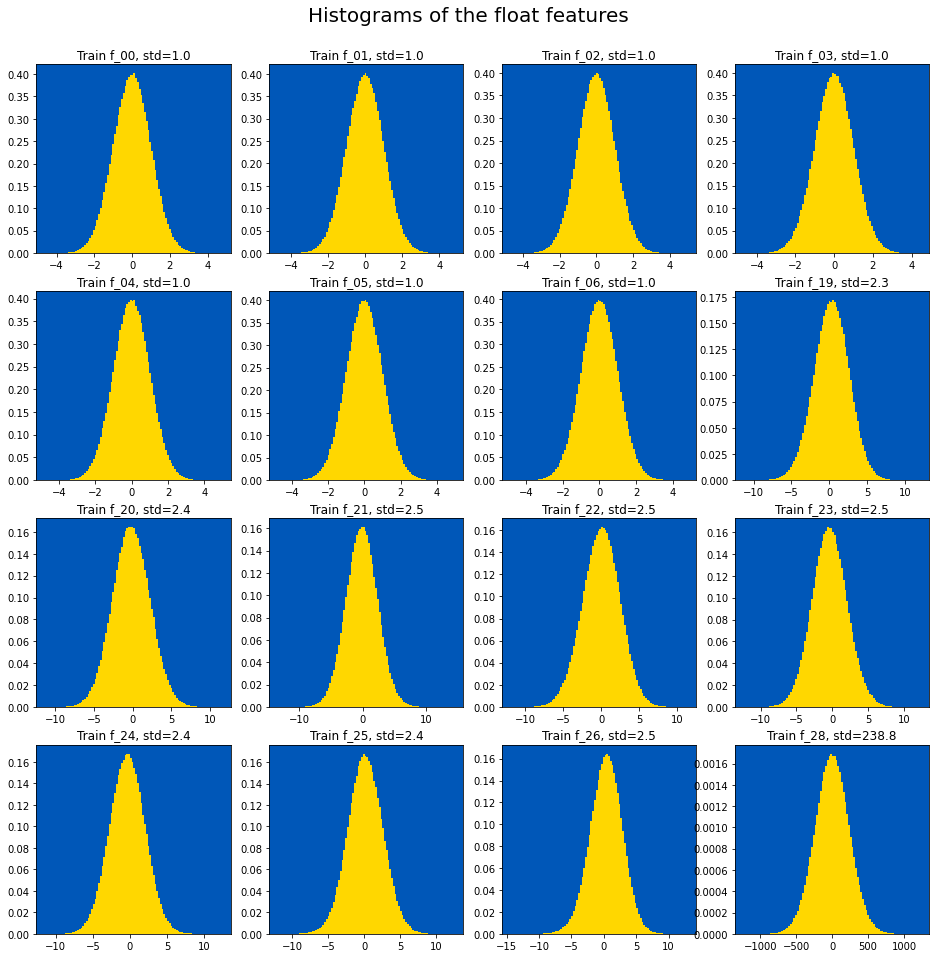

In [5]:
float_features = [f for f in train.columns if train[f].dtype == 'float64']

# Training histograms
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for f, ax in zip(float_features, axs.ravel()):
    ax.hist(train[f], density=True, bins=100)
    ax.set_title(f'Train {f}, std={train[f].std():.1f}')
plt.suptitle('Histograms of the float features', y=0.93, fontsize=20)
plt.show()

# Test histograms
# fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# for f, ax in zip(float_features, axs.ravel()):
#     ax.hist(test[f], density=True, bins=100)
#     ax.set_title(f'Test {f}, std={test[f].std():.1f}')
# plt.show()

The correlation matrix shows:
1. `f_00` through `f_06` are correlated with `f_28`, but not with each other. 
2. `f_19` through `f_26` are all slightly correlated with each other.
3. No feature is strongly correlated with the target.

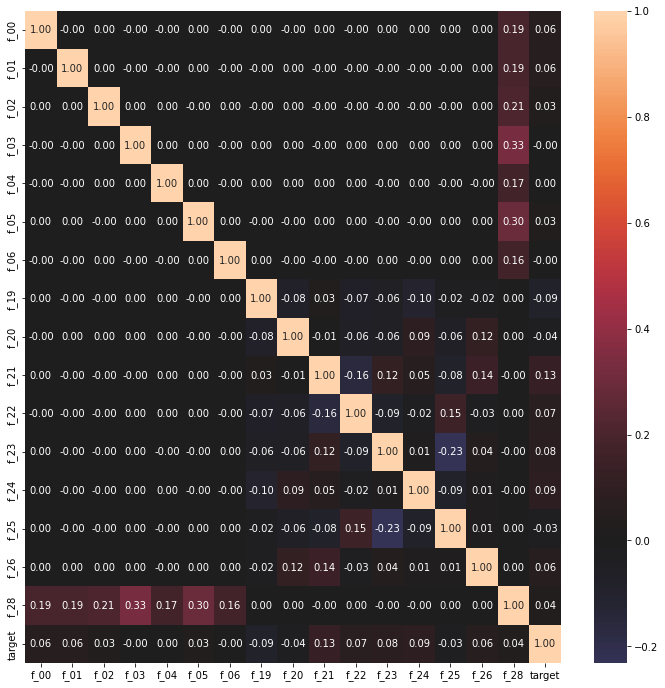

In [6]:
# Correlation matrix of the float features
plt.figure(figsize=(12, 12))
sns.heatmap(train[float_features + ['target']].corr(), center=0, annot=True, fmt='.2f')
plt.show()

The correlation matrix shows only linear dependences. If we plot a rolling mean of the target probability for every feature, we'll see nonlinear dependences as well. A horizontal line means that the target does not depend on the feature (e.g., `f_03`, `f_04`, `f_06`), a line with low minimum and high maximum shows a high mutual information between feature and target (e.g., `f_19`, `f_21`, `f_28`). 

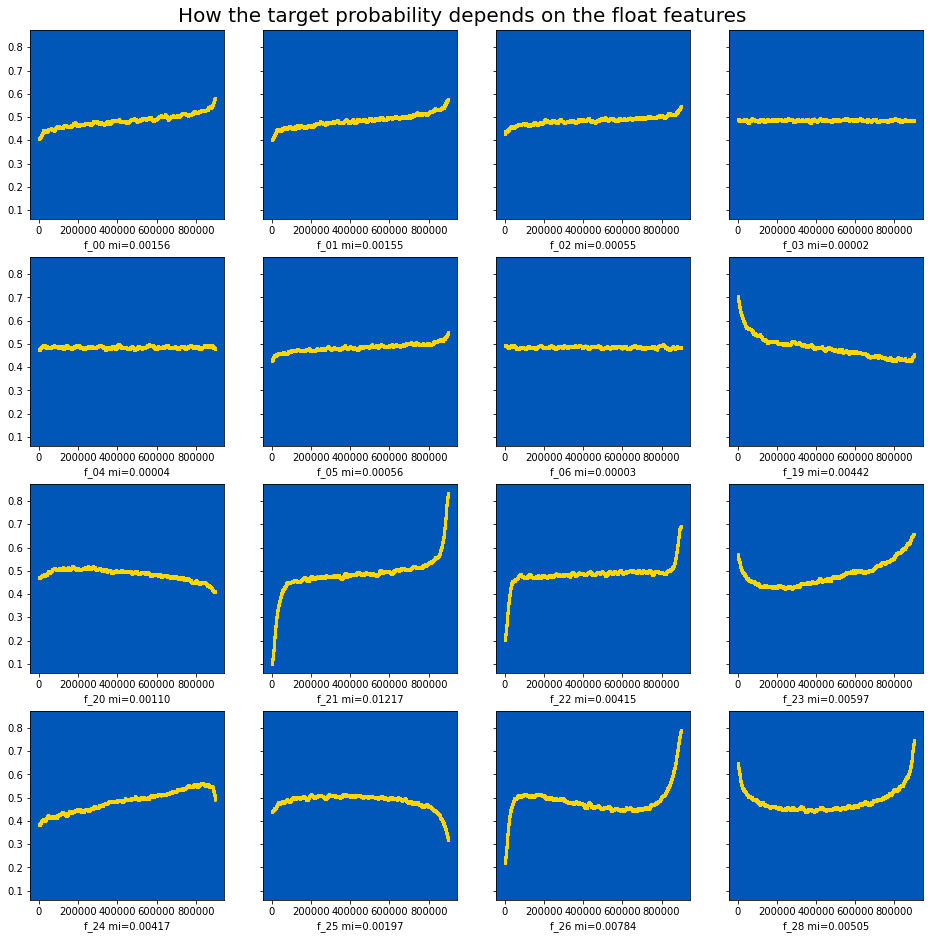

In [7]:
# Plot dependence between every feature and the target
def plot_mutual_info_diagram(df, features, ncols=4, by_quantile=True, mutual_info=True,
                             title='How the target probability depends on single features'):
    def H(p):
        """Entropy of a binary random variable in nat"""
        return -np.log(p) * p - np.log(1-p) * (1-p)
                 
    nrows = (len(features) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(16, nrows*4), sharey=True)
    for f, ax in zip(features, axs.ravel()):
        temp = pd.DataFrame({f: df[f].values,
                             'state': df.target.values})
        temp = temp.sort_values(f)
        temp.reset_index(inplace=True)
        rolling_mean = temp.state.rolling(15000, center=True, min_periods=1).mean()
        if by_quantile:
            ax.scatter(temp.index, rolling_mean, s=2)
        else:
            ax.scatter(temp[f], rolling_mean, s=2)
        if mutual_info and by_quantile:
            ax.set_xlabel(f'{f} mi={H(temp.state.mean()) - H(rolling_mean[~rolling_mean.isna()].values).mean():.5f}')
        else:
            ax.set_xlabel(f'{f}')
    plt.suptitle(title, y=0.90, fontsize=20)
    plt.show()

plot_mutual_info_diagram(train, float_features,
                         title='How the target probability depends on the float features')

**Insight:**
- There are many nonlinear (and some nonmonotonic) relationships. Linear classifiers won't win this competition.

# The integer features

Looking at the histograms of the integer features, we see that the first twelve features all have values between 0 and 16. The last two features are special: `f_29` is binary and `f_30` is ternary.

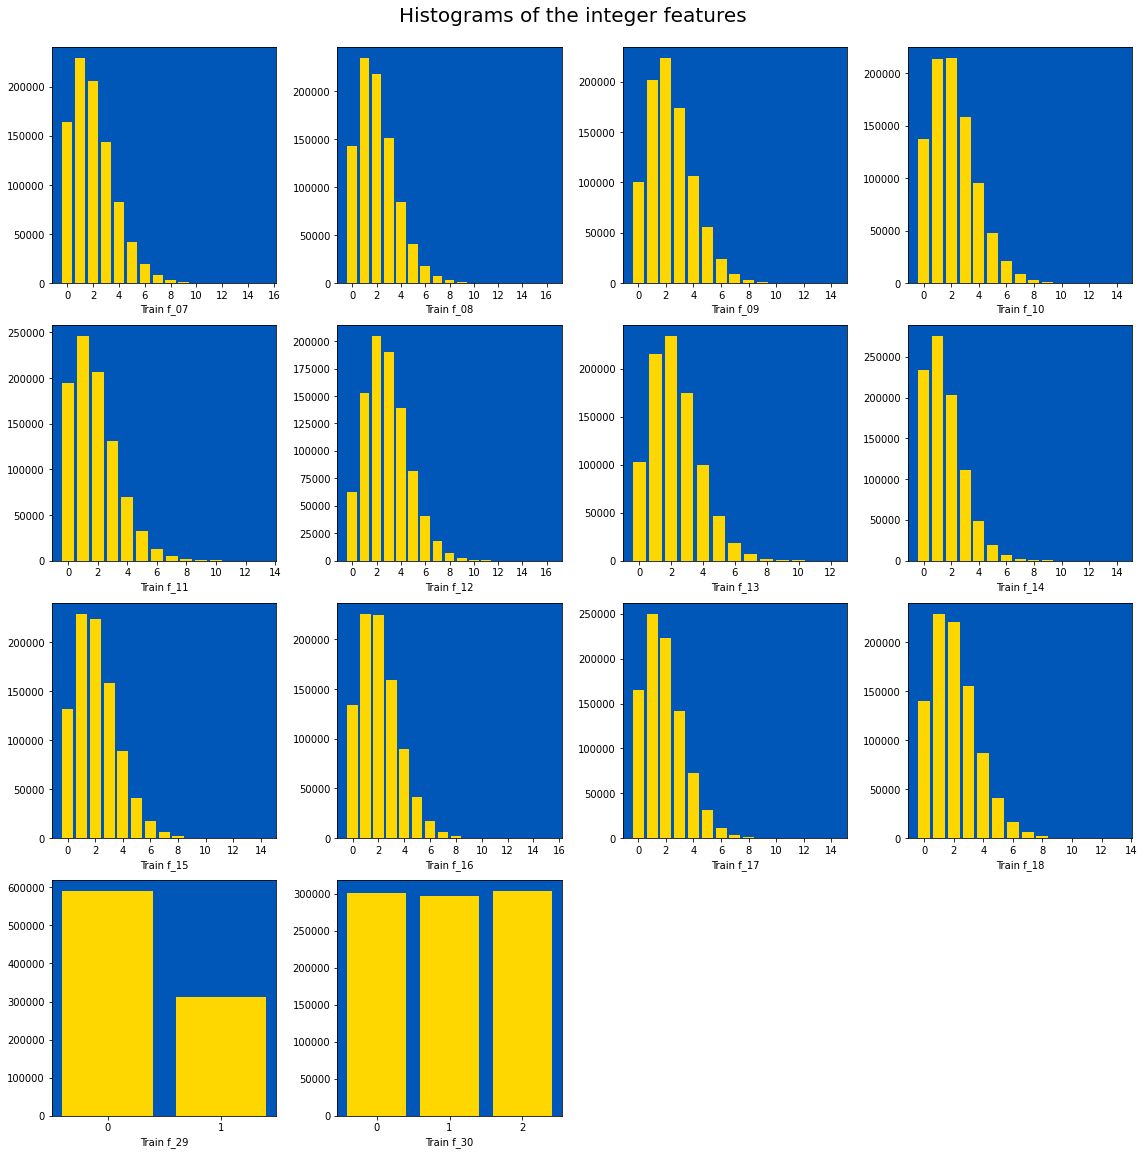

In [8]:
int_features = [f for f in test.columns if test[f].dtype == 'int64' and f != 'id']

# Training histograms
#fig, axs = plt.subplots(4, 4, figsize=(16, 16))
figure = plt.figure(figsize=(16, 16))
# for f, ax in zip(int_features, axs.ravel()):
for i, f in enumerate(int_features):
    plt.subplot(4, 4, i+1)
    ax = plt.gca()
    vc = train[f].value_counts()
    ax.bar(vc.index, vc)
    #ax.hist(train[f], density=False, bins=(train[f].max()-train[f].min()+1))
    ax.set_xlabel(f'Train {f}')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only integer labels
plt.suptitle('Histograms of the integer features', y=1.0, fontsize=20)
figure.tight_layout(h_pad=1.0)
plt.show()

# Test histograms
# fig, axs = plt.subplots(4, 4, figsize=(16, 16))
# for f, ax in zip(int_features, axs.ravel()):
#     ax.hist(test[f], density=True, bins=100)
#     ax.set_title(f'Test {f}, std={test[f].std():.1f}')
# plt.show()

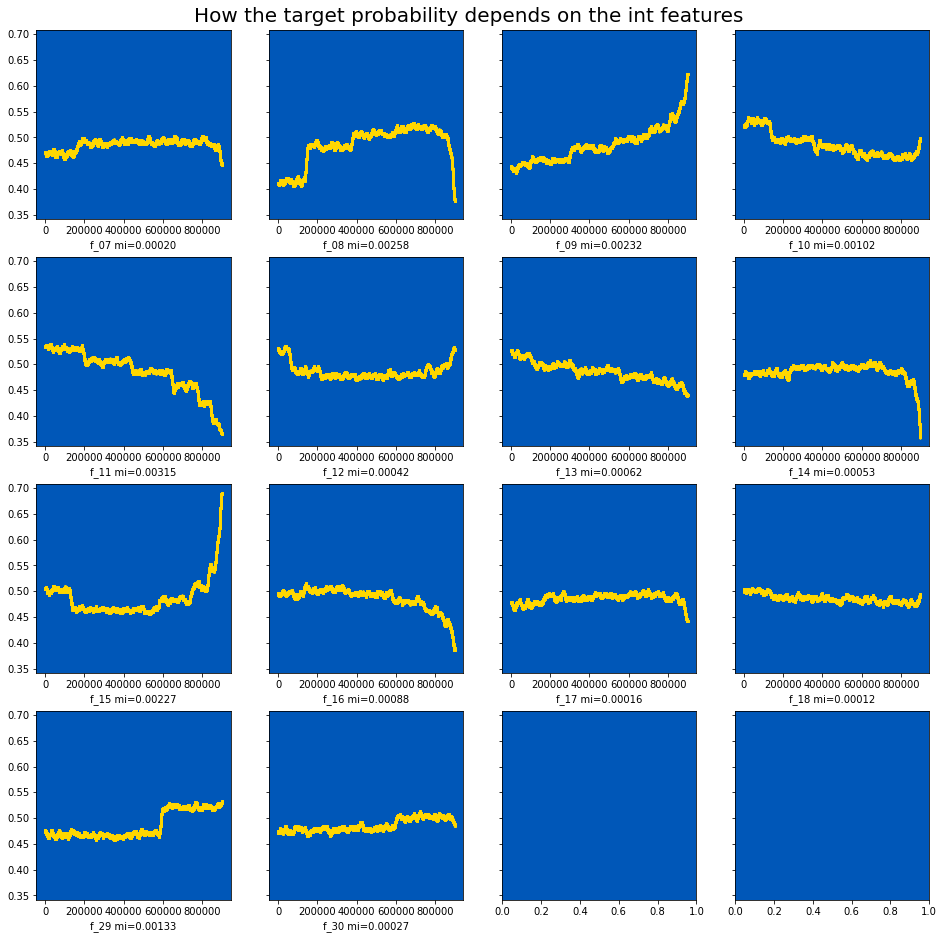

In [9]:
plot_mutual_info_diagram(train, int_features,
                         title='How the target probability depends on the int features')

# The string feature `f_27`

`f_27` is a string feature which cannot be used as a feature as-is. Let's find out how to engineer something useful from it!

We first verify that the string always has length 10:

In [10]:
train.f_27.str.len().min(), train.f_27.str.len().max(), test.f_27.str.len().min(), test.f_27.str.len().max()

(10, 10, 10, 10)

The 900000 train samples contain 741354 different values, i.e. most of the strings are different. The most frequent string, `'BBBBBBCJBC'` occurs only 12 times:

In [11]:
train.f_27.value_counts()

BBBBBBCJBC    12
BCBBBBCLBC    12
BBBBBBDPCB    10
BBBBBBDKBC    10
ADBBBACQBC    10
              ..
BFAFAADTCE     1
BBBDAACOAE     1
BBABAACGBB     1
BFAABAGSDB     1
BCAACADSCE     1
Name: f_27, Length: 741354, dtype: int64

It is important to understand whether the `f_27` strings in test are the same as in training. Unfortunately, test contains 1181880 - 741354 = 440526 strings which do not occur in training. 

**Insight:** We must not use this string as a categorical feature in a classifier. Otherwise, the model learns to rely on strings which never occur in the test data.

In [12]:
pd.concat([train, test]).f_27.value_counts()

BAAACABLBB    15
ACBBAABCBC    15
BAAACABNBC    15
BCBBBBCDCC    14
BBBBBBCJBC    13
              ..
ABBAAAECEB     1
ACBCBAEOAE     1
BBBCBBCACG     1
BBACDAANGA     1
AAAJCBGQBA     1
Name: f_27, Length: 1181880, dtype: int64

In the next step, we look at the distributions of the letters at every one of the ten positions in the string. We see that positions 0, 2 and 5 are binary; the other positions have more values. Every position gives some information about the target (the target means depend on the feature value).

In [13]:
for i in range(10):
    print(f'Position {i}')
    tg = train.groupby(train.f_27.str.get(i))
    temp = pd.DataFrame({'size': tg.size(), 'probability': tg.target.mean().round(2)})
    print(temp)
    print()

Position 0
        size  probability
f_27                     
A     451207         0.54
B     448793         0.44

Position 1
        size  probability
f_27                     
A     144762         0.58
B     245160         0.48
C     225931         0.49
D     149579         0.45
E      78807         0.43
F      35487         0.42
G      13713         0.41
H       4647         0.40
I       1361         0.40
J        410         0.38
K        113         0.39
L         25         0.28
M          3         0.67
N          2         1.00

Position 2
        size  probability
f_27                     
A     297840         0.53
B     602160         0.46

Position 3
        size  probability
f_27                     
A     160839         0.57
B     237218         0.48
C     210015         0.48
D     143633         0.45
E      81662         0.43
F      39504         0.44
G      17121         0.45
H       6473         0.47
I       2379         0.48
J        772         0.51
K        254     

We can as well count the unique characters in the string and use this count as a feature (idea from @cabaxiom's [[TPS-MAY-22] EDA & LGBM Model](https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model)). The table clearly shows that the target probability depends on the unique character count:

In [14]:
unique_characters = train.f_27.apply(lambda s: len(set(s))).rename('unique_characters')
tg = train.groupby(unique_characters)
temp = pd.DataFrame({'size': tg.size(), 'probability': tg.target.mean().round(2)})
print(temp)

                     size  probability
unique_characters                     
1                       1         0.00
2                    1092         0.09
3                   32164         0.09
4                  211165         0.48
5                  399974         0.49
6                  220715         0.48
7                   33698         0.91
8                    1185         0.91
9                       6         1.00


**Insight:**
- The `f_27` strings must be split into ten individual features.
- The count of unique characters in `f_27` is an important feature as well.

You can use the following lines of code to split the strings into ten numerical features:


In [15]:
# From https://www.kaggle.com/ambrosm/tpsmay22-eda-which-makes-sense
for df in [train, test]:
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))


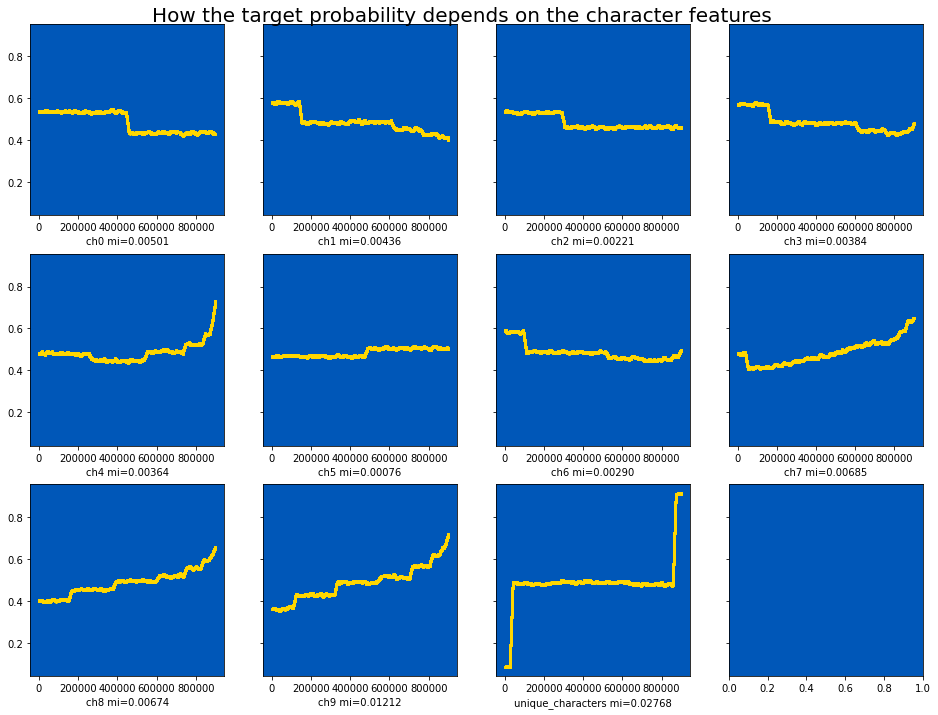

In [16]:
plot_mutual_info_diagram(train, 
                         [f for f in train.columns if f.startswith('ch')] + ['unique_characters'],
                         title='How the target probability depends on the character features')

# Top three feature interactions

In the topic [Interaction vs Correlation](https://www.kaggle.com/competitions/tabular-playground-series-may-2022/discussion/323766), @wti200 has demonstrated that certain 2d projections of the feature space are partitioned into three regions with differing target probabilities. From these diagrams, we can derive the feature interactions. Three projections are particularly useful:
- the projection to f_02 and f_21
- the projection to f_05 and f_22
- the projection to f_00+f_01 and f_26

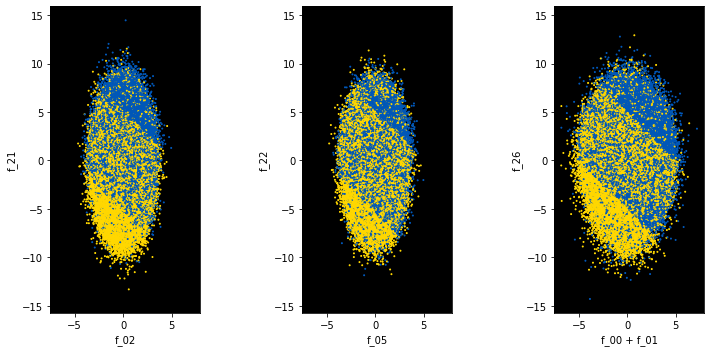

In [17]:
plt.rcParams['axes.facecolor'] = 'k'
plt.figure(figsize=(11, 5))
cmap = ListedColormap(["#ffd700", "#0057b8"])
# target == 0 → yellow; target == 1 → blue

ax = plt.subplot(1, 3, 1)
ax.scatter(train['f_02'], train['f_21'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_02')
ax.set_ylabel('f_21')
ax.set_aspect('equal')
ax0 = ax

ax = plt.subplot(1, 3, 2, sharex=ax0, sharey=ax0)
ax.scatter(train['f_05'], train['f_22'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_05')
ax.set_ylabel('f_22')
ax.set_aspect('equal')

ax = plt.subplot(1, 3, 3, sharex=ax0, sharey=ax0)
ax.scatter(train['f_00'] + train['f_01'], train['f_26'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_00 + f_01')
ax.set_ylabel('f_26')
ax.set_aspect('equal')

plt.tight_layout(w_pad=1.0)
plt.savefig('three-projections.png')
plt.show()
plt.rcParams['axes.facecolor'] = '#0057b8' # blue

We now can either hope that our classifier finds these borders by itself, or we can help the classifier.

And how can we help a classifier? For every projection, we create a ternary categorical feature that indicates to which region a sample belongs:
- Top right region (high probability of target == 1) → +1
- Middle region (medium probability of target == 1) → 0
- Bottom left region (low probability of target == 1) → -1

You can use the following lines of code to add the three features to the dataframes:

In [18]:
for df in [train, test]:
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)


# What next?

If you like gradient-boosted decision trees, you might have a look at the [Gradient Boosting Quickstart](https://www.kaggle.com/ambrosm/tpsmay22-gradient-boosting-quickstart). Or if you prefer neural networks, have a look at the [Advanced Keras Model](https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras).
